In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 48, 48, 3), dtype="float64")
    for i in range(number):
        I = cv2.imread(path + "{:04}_{}.jpeg".format(i+1, train_type))
        I = I[8:-8, 8:-8, :]
        result[i, :, :, :] = I
    return result/result.max()

In [3]:
# mask = np.random.randint(0, 1, (10000, 48, 48, 3))
# x_train1 = np.random.rand(10000, 48, 48, 3) * mask
# x_train2 = np.random.rand(10000, 48, 48, 3) * (1-mask)

# y_train = x_train1 + x_train2 + 0.25*np.random.rand(10000, 48, 48, 3)
# y_train = y_train[:, 8:-8, 8:-8, :]
dataNum = 1000

x1 = load_imgs("./blurImg/", dataNum, 1)
x2 = load_imgs("./blurImg/", dataNum, 2)
y = load_imgs("./blurImg/", dataNum, 0)
y = y[:, 8:-8, 8:-8, :]
x_train1, x_test1, x_train2, x_test2, y_train, y_test = train_test_split(
    x1, x2, y, test_size=0.2)
# mask_test = np.random.randint(0, 1, (2000, 48, 48, 3))
# x_test1 = np.random.rand(2000, 48, 48, 3) * mask_test
# x_test2 = np.random.rand(2000, 48, 48, 3) * (1-mask_test)

# y_test = x_test1 + x_test2 + 0.25*np.random.rand(2000, 48, 48, 3)
# y_test = y_test[:, 8:-8, 8:-8, :]

In [4]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [5]:
# input size: Nonex48x48x3
# output size: Nonex36x36x16
def pre_convblock(x):
    y = layers.Conv2D(filters = 64, kernel_size = (5, 5), padding = "valid", activation = "relu")(x)
    y = layers.Conv2D(filters = 64, kernel_size = (5, 5), padding = "valid", activation = "relu")(y)
    y = layers.Conv2D(filters = 16, kernel_size = (5, 5), padding = "valid", activation = "relu")(y)
    return y

In [6]:
# tensor format: [batch, in_height, in_width, in_channels]
# input size: Nonex36x36x32 (cat: 16+16)
# output size: Nonex32x32x2
# softmax is applied along the channel axis.
def post_convblock(x):
    y = layers.Conv2D(filters = 64, kernel_size=(3, 3), padding = "valid", activation = "relu")(x)
    y = layers.Conv2D(filters = 32, kernel_size=(1, 1), padding = "valid", activation = "relu")(y)
    y = layers.Conv2D(filters = 2, kernel_size=(3, 3), padding = "valid", activation = 'tanh')(y)
#    y = layers.Conv2D(filters = 2, kernel_size=(3, 3), padding = "valid")(y)
    y = layers.Softmax(axis = -1)(y)
    return y

In [7]:
# input: out-of-focus image block A & block B, which denote the same area of the whole picture.
#        each: 48x48x3
# output: 
def fusionnet(inTensor1, inTensor2):
    out1 = pre_convblock(inTensor1)
    out2 = pre_convblock(inTensor2)

    x = layers.Concatenate(axis = -1)([out1, out2])
    y = post_convblock(x)
    
    return y

In [8]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
## crop the input images to the same size as network output.
    inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
    inCrop2 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor2)
    #y1, y2 = tf.split(y, [1, 1], axis = 3)
    ## extend y1&y2 dimension to 3, consistant to color channels
    y1 = y[:, :, :, :1]
    y2 = y[:, :, :, 1:]
#     print(y1.shape)
#     print(y2.shape)
    y1 = K.tile(y1, [1, 1, 1, 3])
    y2 = K.tile(y2, [1, 1, 1, 3])
    y1 = layers.Multiply()([inCrop1, y1])
    y2 = layers.Multiply()([inCrop2, y2])
    y = layers.Add()([y1, y2])
#    print(y)
    return y

In [9]:
img1 = layers.Input(shape=(48, 48, 3))
img2 = layers.Input(shape=(48, 48, 3))
intermed = fusionnet(img1, img2)
# print(intermed)
pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])
# print(pred)

In [10]:
generator = Model(inputs = [img1, img2], outputs = pred)
generator.summary()
generator.compile(loss='mse', optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 44, 44, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 44, 44, 64)   4864        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/10
800/800 [==============================] - 4s 5ms/step - loss: 0.0018
Epoch 2/10
800/800 [==============================] - 1s 755us/step - loss: 0.0016
Epoch 3/10
800/800 [==============================] - 1s 765us/step - loss: 0.0013
Epoch 4/10
800/800 [==============================] - 1s 763us/step - loss: 0.0014
Epoch 5/10
800/800 [==============================] - 1s 759us/step - loss: 0.0011
Epoch 6/10
800/800 [==============================] - 1s 770us/step - loss: 9.3761e-04
Epoch 7/10
800/800 [==============================] - 1s 769us/step - loss: 8.8083e-04
Epoch 8/10
800/800 [==============================] - 1s 764us/step - loss: 8.9667e-04
Epoch 9/10
800/800 [==============================] - 1s 762us/step - loss: 8.3751e-04
Epoch 10/10
800/800 [==============================] - 1s 759us/step - loss: 8.2727e-04


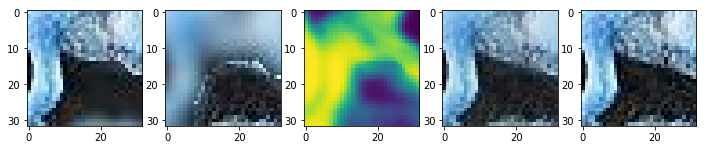

In [11]:
generator.fit([x_train1, x_train2], y_train, epochs=10, batch_size=64)

prediction = generator.predict([x_test1, x_test2])
# print(np.sum(np.square(y_test-prediction)))
# print(np.sum(np.square(y_test-x_test1[:, 8:-8, 8:-8, :]-x_test2[:, 8:-8, 8:-8, :])))

# get image of generated mask
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_test1, x_test2])[0])

img_idx = 100
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(x_test1[img_idx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 2)
plt.imshow(x_test2[img_idx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 3)
plt.imshow(layer_output[img_idx, :, :, 0])
fig.add_subplot(rows, columns, 4)
plt.imshow(prediction[img_idx, :, :, :])
fig.add_subplot(rows, columns, 5)
plt.imshow(y_test[img_idx, :, :, :])
plt.show()

In [12]:
### ERROR REASON: activation function should have ()

# discriminator = Sequential()
# discriminator.add(layers.Conv2D(filters = 32, 
#                                 kernel_size = (5, 5), 
#                                 strides = (2, 2), 
#                                 padding='same', activation = layers.LeakyReLU, input_shape=(32,32,3)))
# discriminator.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 1),
#                                padding='same', activation = layers.LeakyReLU))
# discriminator.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2),
#                                padding='same', activation = layers.LeakyReLU))
# discriminator.add(layers.Conv2D(filters = 128, kernel_size = (5, 5), strides = (1, 1),
#                                padding='same', activation = layers.LeakyReLU))
# discriminator.add(layers.Conv2D(filters = 128, kernel_size = (5, 5), strides = (4, 4),
#                                padding='same', activation = layers.LeakyReLU))
# discriminator.add(layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1),
#                                padding='same', activation = layers.LeakyReLU))
# discriminator.add(layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (4, 4),
#                                padding='same', activation = layers.LeakyReLU))
# discriminator.add(layers.Flatten())
# discriminator.add(layers.Dense(1, activation='sigmoid'))

In [13]:
def disnet(x):
    y = layers.Conv2D(filters = 32, kernel_size = (5, 5), strides = (2, 2), 
                      padding='same')(x)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2),
                      padding='same')(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2),
                      padding='same')(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(filters = 128, kernel_size = (5, 5), strides = (2, 2),
                      padding='same')(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(filters = 128, kernel_size = (5, 5), strides = (2, 2),
                      padding='same')(y)
    y = layers.LeakyReLU()(y)
#     y = layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1),
#                                padding='same', activation = layers.LeakyReLU())(y)
#     y = layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (4, 4),
#                                padding='same', activation = layers.LeakyReLU())(y)
    y = layers.Flatten()(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    return y

In [14]:
dis_input = layers.Input(shape=(32, 32, 3))
dis_output = disnet(dis_input)
discriminator = Model(inputs = dis_input, outputs = dis_output)
# make_trainable(discriminator, False)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 64)          0         
__________

In [15]:
def gannet(x):
    img1, img2 = x
    pred = generator([img1, img2])
    prob = discriminator(pred)
    discriminator.trainable = False
    return prob

In [16]:
prob = gannet([img1, img2])
gan = Model(inputs = [img1, img2], outputs= prob)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    287042      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            770945      model_1[1][0]                    
Total para

In [17]:
# discriminator.trainable = False
# gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# gan.summary()
# discriminator.trainable = True
# discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# discriminator.summary()

In [18]:
fig.add_subplot(rows, columns, 1)
plt.imshow(x_train1[img_idx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 2)
plt.imshow(x_train2[img_idx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 3)
plt.imshow(layer_output[img_idx, :, :, 0])
fig.add_subplot(rows, columns, 4)
plt.imshow(prediction[img_idx, :, :, :])
fig.add_subplot(rows, columns, 5)
plt.imshow(y_train[img_idx, :, :, :])
plt.show()epoch = 100
batchSize = 32
losses = {"d":[], "g":[]}
for e in range(epoch):
    rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
    img_batch1 = x_train1[rand_idx, :, :, :]
    img_batch2 = x_train2[rand_idx, :, :, :]
    y_batch = y_train[np.random.randint(0, y_train.shape[0], size = batchSize), :, :, :]
    img_fake = generator.predict([img_batch1, img_batch2])
    img_valid = y_batch
    dis_input = np.concatenate((img_fake, img_valid), axis = 0)
    label = np.append(np.zeros((batchSize, )), np.ones((batchSize, )))
    #make_trainable(discriminator, True)
    discriminator.trainable = True
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #discriminator.summary()
    d_loss = discriminator.train_on_batch(dis_input, label)
    losses["d"].append(d_loss)
    
    
    gan_label = np.ones((batchSize,))
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #gan.summary()
    g_loss = gan.train_on_batch([img_batch1, img_batch2], gan_label)
    losses["g"].append(g_loss)

Epoch 1/1
64/64 [==============================] - 0s 7ms/step - loss: 0.7018 - acc: 0.3438
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.6956 - acc: 0.0000e+00
Epoch 1/1
64/64 [==============================] - 0s 6ms/step - loss: 0.6939 - acc: 0.4688
Epoch 1/1
32/32 [==============================] - 1s 18ms/step - loss: 0.7115 - acc: 0.0000e+00
Epoch 1/1
64/64 [==============================] - 0s 7ms/step - loss: 0.6915 - acc: 0.4688
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.7543 - acc: 0.0625
Epoch 1/1
64/64 [==============================] - 1s 8ms/step - loss: 0.6901 - acc: 0.5312
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 0.8668 - acc: 0.0625
Epoch 1/1
64/64 [==============================] - 1s 9ms/step - loss: 0.7099 - acc: 0.4531
Epoch 1/1
32/32 [==============================] - 1s 25ms/step - loss: 0.6211 - acc: 1.0000
Epoch 1/1
64/64 [==============================] - 1s 10ms/step - l

Epoch 1/1
64/64 [==============================] - 4s 65ms/step - loss: 0.6947 - acc: 0.4844
Epoch 1/1
32/32 [==============================] - 4s 134ms/step - loss: 0.7077 - acc: 0.0000e+00
Epoch 1/1
64/64 [==============================] - 4s 66ms/step - loss: 0.6901 - acc: 0.5938
Epoch 1/1
32/32 [==============================] - 4s 135ms/step - loss: 0.6007 - acc: 0.9375
Epoch 1/1
64/64 [==============================] - 4s 67ms/step - loss: 0.6880 - acc: 0.5781
Epoch 1/1
32/32 [==============================] - 4s 140ms/step - loss: 0.7209 - acc: 0.0625
Epoch 1/1
64/64 [==============================] - 4s 68ms/step - loss: 0.6875 - acc: 0.5312
Epoch 1/1
32/32 [==============================] - 5s 145ms/step - loss: 0.7125 - acc: 0.1875
Epoch 1/1
64/64 [==============================] - 4s 69ms/step - loss: 0.7016 - acc: 0.5625
Epoch 1/1
32/32 [==============================] - 5s 145ms/step - loss: 0.7203 - acc: 0.1250
Epoch 1/1
64/64 [==============================] - 5s 71ms/st

32/32 [==============================] - 9s 285ms/step - loss: 0.7484 - acc: 0.1250
Epoch 1/1
64/64 [==============================] - 9s 142ms/step - loss: 0.7117 - acc: 0.5000
Epoch 1/1
32/32 [==============================] - 9s 283ms/step - loss: 0.7382 - acc: 0.0000e+00
Epoch 1/1
64/64 [==============================] - 9s 145ms/step - loss: 0.6951 - acc: 0.5312
Epoch 1/1
32/32 [==============================] - 9s 293ms/step - loss: 0.7123 - acc: 0.1250
Epoch 1/1
64/64 [==============================] - 9s 141ms/step - loss: 0.6927 - acc: 0.5625
Epoch 1/1
32/32 [==============================] - 9s 297ms/step - loss: 0.6350 - acc: 0.7188
Epoch 1/1
64/64 [==============================] - 9s 142ms/step - loss: 0.7802 - acc: 0.5312
Epoch 1/1
32/32 [==============================] - 9s 295ms/step - loss: 0.6521 - acc: 0.7188
Epoch 1/1
64/64 [==============================] - 10s 151ms/step - loss: 0.6923 - acc: 0.5312
Epoch 1/1
32/32 [==============================] - 10s 307ms/step

KeyboardInterrupt: 

In [28]:
prediction = generator.predict([x_train1, x_train2])
# print(np.sum(np.square(y_test-prediction)))
# print(np.sum(np.square(y_test-x_test1[:, 8:-8, 8:-8, :]-x_test2[:, 8:-8, 8:-8, :])))

# get image of generated mask
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_train1, x_train2])[0])

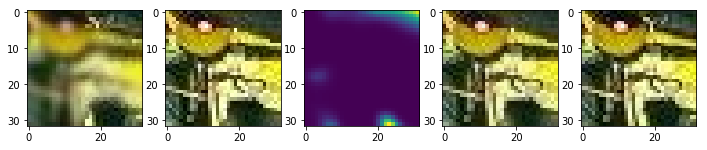

In [36]:
img_idx = 345
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(x_train1[img_idx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 2)
plt.imshow(x_train2[img_idx, 8:-8, 8:-8, :])
fig.add_subplot(rows, columns, 3)
plt.imshow(layer_output[img_idx, :, :, 0])
fig.add_subplot(rows, columns, 4)
plt.imshow(prediction[img_idx, :, :, :])
fig.add_subplot(rows, columns, 5)
plt.imshow(y_train[img_idx, :, :, :])
plt.show()